In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip "drive/My Drive/data/img_align_celeba.zip";

In [0]:
!mkdir celeba
!mv img_align_celeba ./celeba/
!ls ./
!ls ./celeba

celeba	drive  sample_data
img_align_celeba


In [0]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import HTML
rand_seed = 999
random.seed(rand_seed)
torch.manual_seed(rand_seed)
print('Random seed: {}'.format(rand_seed))
data_root = 'celeba'
image_size = 64
batch_size = 128
num_workers = 16
num_channels = 3
num_zs = 100
num_gen_features = 128
num_disc_features = 128
num_epochs = 5
lr = 0.0002
beta1 = 0.5

Random seed: 999


In [0]:
dataset = dset.ImageFolder(root=data_root,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5),
                                                   (0.5, 0.5, 0.5))
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)
device = torch.device('cuda:0' if (torch.cuda.is_available()) else 'cpu')
print(device)

cuda:0


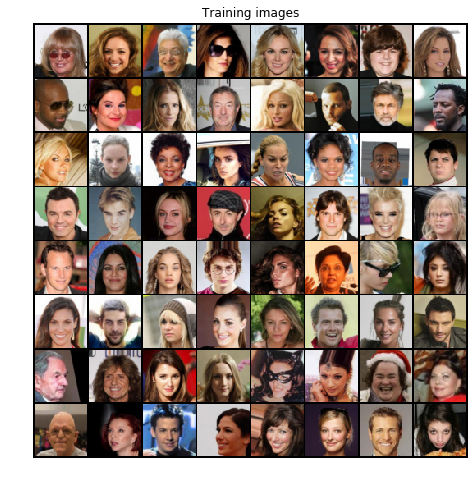

In [0]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('Training images')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64],
                                         padding=2, normalize=True).cpu(),
                       (1,2,0)))

In [0]:
def init_weights(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [0]:
# generator
class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
        # input is num_zs x 1 x 1
        nn.ConvTranspose2d(num_zs, num_gen_features*8,
                           4, 1, 0, bias=False),
        nn.Dropout(p=0.2),
        nn.BatchNorm2d(num_gen_features*8),
        nn.ReLU(True),
        # state size: (num_gen_features*8)x4x4
        nn.ConvTranspose2d(num_gen_features*8, num_gen_features*4,
                           4, 2, 1, bias=False),
        nn.Dropout(p=0.2),
        nn.BatchNorm2d(num_gen_features*4),
        nn.ReLU(True),
        # state size: (num_gen_features*4)x8x8
        nn.ConvTranspose2d(num_gen_features*4, num_gen_features*2,
                           4, 2, 1, bias=False),
        nn.Dropout(p=0.2),
        nn.BatchNorm2d(num_gen_features*2),
        nn.ReLU(True),
        # state size: (num_gen_features*2)x16x16
        nn.ConvTranspose2d(num_gen_features*2, num_gen_features,
                           4, 2, 1, bias=False),
        nn.Dropout(p=0.2),
        nn.BatchNorm2d(num_gen_features),
        nn.ReLU(True),
        # state size: (num_gen_features)x32x32
        nn.ConvTranspose2d(num_gen_features, num_channels,
                           4, 2, 1, bias=False),
        nn.Tanh()
        # output size: num_channels x 64 x 64
    )
  def forward(self, input):
    return self.main(input)

In [0]:
netGenerator = Generator(1).to(device)
netGenerator.apply(init_weights)
print(netGenerator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): Dropout(p=0.2)
    (2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace)
    (4): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): Dropout(p=0.2)
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace)
    (8): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): Dropout(p=0.2)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Dropout(p=0.2)
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU(inplace)
    (16): ConvTranspose2d(128, 3, 

In [0]:
class Discriminator(nn.Module):
  def __init__(self, ngpu):
    super(Discriminator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
        # input is num_channels x 64 x 64
        nn.Conv2d(num_channels, num_disc_features, 4, 2, 1, bias=False),
        nn.Dropout(p=0.2),
        nn.LeakyReLU(0.2, inplace=True),
        # state size: num_disc_features x 32 x 32
        nn.Conv2d(num_disc_features, num_disc_features*2,
                  4, 2, 1, bias=False),
        nn.Dropout(p=0.2),
        nn.BatchNorm2d(num_disc_features * 2),
        nn.LeakyReLU(0.2, inplace=True),
        # state size: (num_disc_features*2) x 16 x 16
        nn.Conv2d(num_disc_features*2, num_disc_features*4,
                  4, 2, 1, bias=False),
        nn.Dropout(p=0.2),
        nn.BatchNorm2d(num_disc_features * 4),
        nn.LeakyReLU(0.2, inplace=True),
        # state size: (num_disc_features*4) x 8 x 8
        nn.Conv2d(num_disc_features*4, num_disc_features*8,
                  4, 2, 1, bias=False),
        nn.Dropout(p=0.2),
        nn.BatchNorm2d(num_disc_features * 8),
        nn.LeakyReLU(0.2, inplace=True),
        # state size: (num_disc_features*8) x 4 x 4
        nn.Conv2d(num_disc_features*8, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
    )
  def forward(self, input):
    return self.main(input)

In [0]:
netDiscriminator = Discriminator(1).to(device)
netDiscriminator.apply(init_weights)
print(netDiscriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): Dropout(p=0.2)
    (2): LeakyReLU(negative_slope=0.2, inplace)
    (3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): Dropout(p=0.2)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace)
    (7): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): Dropout(p=0.2)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): Dropout(p=0.2)
    (13): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.2, inplace)
    (15): Conv2d(1024, 1, kernel_size=(4, 4)

In [0]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64,num_zs, 1,1, device=device)
real_label = 1
fake_label = 0

optimizerGenerator = optim.Adam(netGenerator.parameters(), lr=lr,
                                betas=(beta1, 0.999))
optimizerDiscriminator = optim.Adam(netDiscriminator.parameters(), lr=lr,
                                betas=(beta1, 0.999))

In [0]:
img_list = []
generator_losses = []
discriminator_losses = []
iters = 0
print('Starting training...')
for epoch in range(num_epochs):
  for i, data in enumerate(dataloader, 0):
    # (1) update discriminator: maximize log(D(x)) + log(1-D(G(z)))
    ## first all-real batch
    netDiscriminator.zero_grad()
    real_b = data[0].to(device)
    b_size = real_b.size(0)
    label = torch.full((b_size, ), real_label, device=device)
    # forward pass
    output = netDiscriminator(real_b).view(-1)
    # error on all-real batch:
    err_disc_real = criterion(output, label)
    # gradients
    err_disc_real.backward()
    disc_x = output.mean().item()
    
    ## train with all-fake batch
    noise = torch.randn(b_size, num_zs, 1, 1, device=device)
    # generate fake images
    fake = netGenerator(noise)
    label.fill_(fake_label)
    # classify
    output = netDiscriminator(fake.detach()).view(-1)
    err_disc_fake = criterion(output, label)
    err_disc_fake.backward()
    disc_gen_x1 = output.mean().item()
    err_disc = err_disc_real + err_disc_fake
    optimizerDiscriminator.step()
    
    # (2) update generator: maximize log(D(G(z)))
    netGenerator.zero_grad()
    label.fill_(real_label)
    # we're trying to trick the discriminator
    # so tell it the images are real
    output = netDiscriminator(fake).view(-1)
    # recompute the discriminator output since we updated the weightts before
    err_gen = criterion(output, label)
    err_gen.backward()
    disc_gen_x2 = output.mean().item()
    optimizerGenerator.step()
    
    if i % 50 == 0:
      print('[{}/{}][{}/{}]\tLoss_D: {:.4f}\tLoss_G: {:.4f}\tD(x): {:.4f}\tD(G(z)): {:.4f} / {:.4f}'.format(
            epoch, num_epochs, i, len(dataloader),
            err_disc.item(), err_gen.item(), disc_x, disc_gen_x1, disc_gen_x2))
    generator_losses.append(err_gen.item())
    discriminator_losses.append(err_disc.item())
    
    if (iters % 100 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
      with torch.no_grad():
        fake = netGenerator(fixed_noise).detach().cpu()
      img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
    iters+=1

Starting training...
[0/5][0/1583]	Loss_D: 1.5970	Loss_G: 2.9339	D(x): 0.5164	D(G(z)): 0.4110 / 0.1218
[0/5][50/1583]	Loss_D: 0.0349	Loss_G: 25.5344	D(x): 0.9799	D(G(z)): 0.0000 / 0.0000
[0/5][100/1583]	Loss_D: 0.0005	Loss_G: 41.5725	D(x): 0.9995	D(G(z)): 0.0000 / 0.0000
[0/5][150/1583]	Loss_D: 0.0005	Loss_G: 29.7637	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[0/5][200/1583]	Loss_D: 0.0003	Loss_G: 39.4339	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[0/5][250/1583]	Loss_D: 0.0000	Loss_G: 36.2913	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][300/1583]	Loss_D: 0.0005	Loss_G: 40.6393	D(x): 0.9995	D(G(z)): 0.0000 / 0.0000
[0/5][350/1583]	Loss_D: 0.0000	Loss_G: 39.0476	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][400/1583]	Loss_D: 1.7927	Loss_G: 51.1634	D(x): 0.6931	D(G(z)): 0.0000 / 0.0000
[0/5][450/1583]	Loss_D: 0.0005	Loss_G: 45.0738	D(x): 0.9995	D(G(z)): 0.0000 / 0.0000
[0/5][500/1583]	Loss_D: 0.0000	Loss_G: 44.5324	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][550/1583]	Loss_D: 0.0000	Loss_G: 44.1243	D

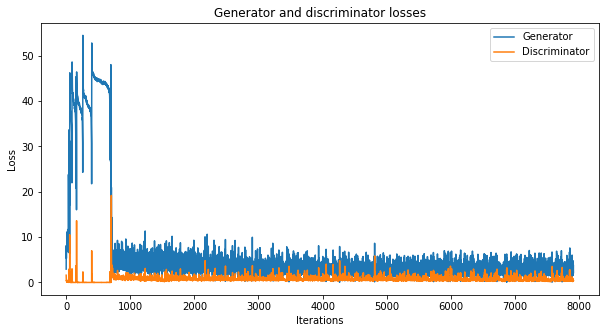

In [0]:
plt.figure(figsize=(10,5))
plt.title('Generator and discriminator losses')
plt.plot(generator_losses,label='Generator')
plt.plot(discriminator_losses, label='Discriminator')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

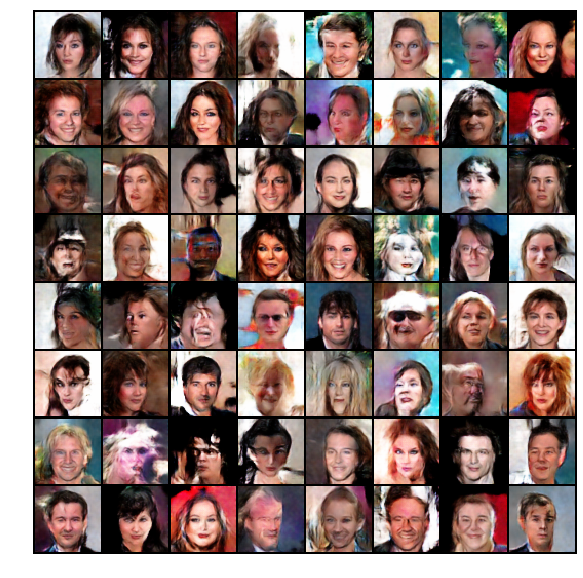

In [0]:
#%%capture
fig = plt.figure(figsize=(10,10))
plt.axis('off')
ims = [[plt.imshow(np.transpose(i, (1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=100, repeat_delay=1000, blit=True)
HTML(ani.to_html5_video())